In [1]:
!pip install pyfhel
!pip install -q plot_keras_history
!pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 767.4 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/home/wubu/miniconda3/envs/gpy12/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/home/wubu/miniconda3/envs/gpy12/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/home/wubu/miniconda3/envs/gpy12/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 112, in get_requires_for_build_wheel
   

In [2]:
GOOGLE_COLAB = True
PROJECT_FOLDER = ''
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    PROJECT_FOLDER = '/content/gdrive/My Drive/ds/'

ModuleNotFoundError: No module named 'google'

In [ ]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
#import keras_tuner as kt
from keras.models import load_model

import matplotlib
from os.path import exists

from sklearn.metrics import mean_squared_error
import numpy as np

import seaborn as sns
import pandas as pd

from tensorflow.keras.models import load_model

HYPARAMETER_TUNING = False
TRAIN_MODEL = False
GOOGLE_COLAB = True



np.random.seed(10)

In [ ]:
!wget -q -O data.mat https://github.com/ocatak/6g-channel-estimation-dataset/blob/main/data.mat?raw=true

In [ ]:
data = scipy.io.loadmat('data.mat')

trainData = data['trainData'].transpose((3,0,1,2))
trainLabels = data['trainLabels'].transpose((3,0,1,2))
valData = data['valData'].transpose((3,0,1,2))
valLabels = data['valLabels'].transpose((3,0,1,2))

In [ ]:
print(trainData.shape)
print(valData.shape)


(480, 612, 14, 1)
(32, 612, 14, 1)


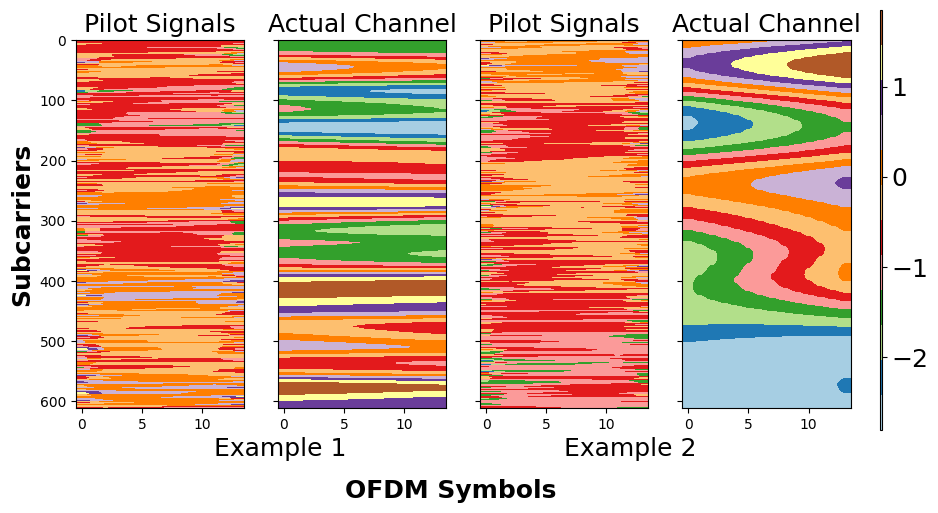

In [ ]:
cmap_name = 'Paired'
font_size = 18

rand_idx = np.random.randint(0,valData.shape[0],2)

test_input1 = valData[rand_idx[0]:rand_idx[0]+1,:]
real_output1 = valLabels[rand_idx[0]:rand_idx[0]+1,:]

test_input2 = valData[rand_idx[1]:rand_idx[1]+1,:]
real_output2 = valLabels[rand_idx[1]:rand_idx[1]+1,:]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Pilot Signals',fontsize=font_size)

ax[3].imshow(real_output2.reshape(612,14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title('Actual Channel',fontsize=font_size)

ax[0].set_ylabel('Subcarriers',fontsize=font_size, fontweight='bold')
fig.text(0.5,0.05, "OFDM Symbols", ha="center", va="center", fontsize=font_size, fontweight='bold')
fig.text(0.33,0.12, "Example 1", ha="center", va="center", fontsize=font_size, fontweight='normal')
fig.text(0.68,0.12, "Example 2", ha="center", va="center", fontsize=font_size, fontweight='normal')

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1,cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size)

plt.show()

In [ ]:
def get_model(mult_factor = 1.0, model_name=''):
    model = models.Sequential(name=model_name)
    # selu, softplus, selu
    model.add(layers.Conv2D(int(48*mult_factor), (9, 9), padding='same', activation='selu', input_shape=(612, 14, 1)))
    model.add(layers.Conv2D(int(16*mult_factor), (5, 5), padding='same', activation='softplus'))
    model.add(layers.Conv2D(1, (5, 5),  padding='same', activation='selu'))

    return model

In [ ]:
model = get_model(1.0, model_name = 'FL-model')

es_teacher = EarlyStopping(monitor='val_loss',
                          patience=50,
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.

hist_model = model.fit(trainData, trainLabels,
              epochs=10,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))


DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

In [ ]:
model.summary()

Model: "FL-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 612, 14, 48)       3936      
                                                                 
 conv2d_1 (Conv2D)           (None, 612, 14, 16)       19216     
                                                                 
 conv2d_2 (Conv2D)           (None, 612, 14, 1)        401       
                                                                 
Total params: 23,553
Trainable params: 23,553
Non-trainable params: 0
_________________________________________________________________


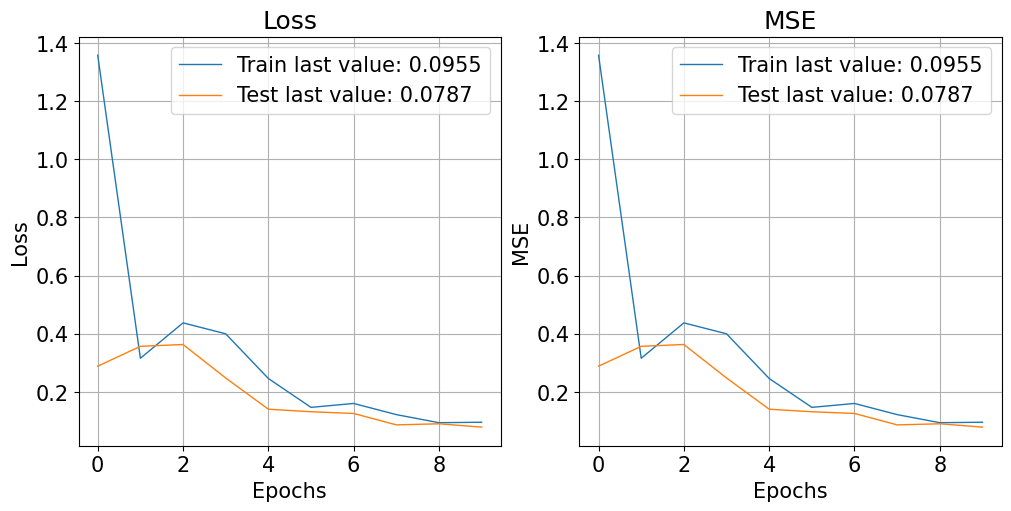

In [ ]:

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plot_history(hist_model.history)
plt.savefig("undefended_training_history.pdf",bbox_inches='tight')
plt.show()


In [ ]:
# model.summary()

In [ ]:
from Pyfhel import Pyfhel, PyPtxt, PyCtxt
import time

In [ ]:
def gen_pk(s=128, alg_type='BFV'):
  HE = Pyfhel()

  HE.contextGen(scheme=alg_type, sec = s,n=65537,t_bits=0, t=65537)
  HE.keyGen()
  #HE.relinKeyGen(60,4096)

  keys ={}
  keys['HE'] = HE
  keys['con'] = HE.to_bytes_context()
  keys['pk'] = HE.to_bytes_publicKey()

  return HE

In [ ]:
def prep_df(num_of_clients,shuffle=True):
  trainData, trainLabels
  splitted_trainData = np.array_split(trainData,num_of_clients)
  splitted_trainLabels = np.array_split(trainLabels,num_of_clients)
  print (len(splitted_trainData))
  for i in range(len(splitted_trainData)):
    np.savez('client-' + str(i) + '.npz',
             trainData=splitted_trainData[i],
             trainLabels=splitted_trainLabels[i])


In [ ]:
# def gen_pk(s, alg_type):
#     HE = Pyfhel()

#     # Assuming p=65537 and sec=s for contextGen
#     HE.contextGen(p=65537, sec=s)
#     HE.keyGen()
#     # Additional key generation steps if needed

#     return HE

In [ ]:
SECRET_LEVEL = 192
LEVEL_N = 1024
ALG_TYPE = 'BFV'

HE = Pyfhel()
HE.contextGen(p=65537, sec=SECRET_LEVEL)
HE.keyGen()

keys = {}
keys['HE'] = HE
keys['con'] = HE.to_bytes_context()
keys['pk'] = HE.to_bytes_publicKey()

TypeError: contextGen() takes at least 2 positional arguments (0 given)

In [ ]:
import pickle,os

def encrypt_model(client_id):
  model_weight = np.load('weights' + str(client_id)+ '.npz', allow_pickle=True)
  model_weight = model_weight['arr_0']
  encrypted_weights={}

  for i in tqdm(range(len(model_weight)), desc='Model Encryption'):
    weights = model_weight[i]
    shape = weights.shape
    weights = weights.flatten()
    array= np.empty(len(weights),dtype=PyCtxt)
    for k in np.arange(len(weights)):
      array[k] = HE.encryptFrac(weights[k])

    enc_array = array.reshape(shape)
    encrypted_weights['c_'+str(i)] = enc_array

    filename =  "weights/client_" + str(client_id)+ ".pickle"

  dic = {}
  dic['key']=HE
  dic['val']=encrypted_weights

  if os.path.exists('weights') == False:
    os.makedirs('weights')

  with open(filename, 'wb') as handle:
      pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

#encrypt_model(0)

In [ ]:
def aggregate_models(num_client):
  dct_weights ={}
  denom = float(1.0/num_client)
  #print('denom =',denom)
  denom = HE.encryptFrac(denom)

  filename =  "weights/client_0.pickle"
  key_list = None
  with open(filename, 'rb') as handle:
      dct = pickle.load(handle)
      cweights=dct['val']
      key_list = list(cweights.keys())


  for key in key_list:
    for client_id in tqdm(range(num_client),desc='Model aggregation:' + key):
      filename =  "weights/client_" + str(client_id)+ ".pickle"
      with open(filename, 'rb') as handle:
        dct = pickle.load(handle)

        cweights=dct['val']
        enc_weights={}

        #print(key)
        arr = cweights[key]

        shape = arr.shape
        weight = arr.flatten()

        if client_id == 0:
          dct_weights[key] = np.zeros_like(arr,dtype=PyCtxt).flatten()
          #for j in range(len(dct_weights[key])):
          #  dct_weights[key][j] = HE.encryptFrac(0.0)

        for j in range(len(dct_weights[key])):
          tmp1 = weight[j]
          tmp2 = dct_weights[key][j]
          tmp1._pyfhel = HE

          dct_weights[key][j] = tmp1 + tmp2

    dct_weights[key]= dct_weights[key] * denom

  dic = {}
  dic['key']=HE
  dic['val']=dct_weights

  with open('global_encrypted.pickle', 'wb') as handle:
      pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def decrypt_import_weights():
  weights={}
  model = get_model(1.0, model_name = 'FL-model')

  with open('global_encrypted.pickle', 'rb') as handle:
    dct = pickle.load(handle)

  cweights=dct['val']
  HE2 = dct['key']
  dec_weights={}

  # print(cweights)
  for key in cweights:
    #print('key',key)
    arr = cweights[key]
    shape = arr.shape
    weight = arr.flatten()

    for l in range(len(weight)):
      weight[l]= HE.decryptFrac(weight[l])

    dec_array = weight.reshape(shape)
    dec_weights[key] = dec_array

  for i in tqdm(range(len(model.layers)),leave=True, desc="Decrypt and merge layers"):
    if model.layers[i].get_weights()!=[]:

      shape = model.layers[i].get_weights()[0].shape
      tmp_key1 = list(dec_weights.keys())[i*2]
      tmp_key2 = list(dec_weights.keys())[i*2 + 1]
      weight = []
      weight.append(dec_weights[tmp_key1].reshape(shape))
      weight.append(dec_weights[tmp_key2])
      model.layers[i].set_weights(weight)
  return model

In [ ]:
num_of_client_list = [3,4,5,6,7,8,9]
#num_of_client_list = [9]
t =[]
real_mse_list = []

NUM_OF_EXPERIMENTS = 10

model = get_model(1.0, model_name = 'FL-model')
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

model.save('main_model.hdf5')


for j, num_client in enumerate(num_of_client_list):
  prep_df(num_client)
  '''
  HE=gen_pk(s=SECRET_LEVEL)
  keys ={}
  keys['HE'] = HE
  keys['con'] = HE.to_bytes_context()
  keys['pk'] = HE.to_bytes_publicKey()
  keys['sk'] = HE.to_bytes_secretKey()
  '''

  #HE.relinKeyGen(30,2048)

  for iter_no in tqdm(range(NUM_OF_EXPERIMENTS), desc= "Number of clients: " + str(num_client)):
    start = time.time()

    #model = load_model('main_model.hdf5')
    real_mse_list = []
    #print("Train Clients")
    for i in tqdm(range(num_client), position=0, leave=True):
      client_data = np.load('client-' + str(i) + '.npz')
      client_trainData = client_data['trainData']
      client_trainLabels = client_data['trainLabels']

      es_teacher = EarlyStopping(monitor='val_loss',
                      patience=5 + int(iter_no*15),
                      verbose=0,
                      restore_best_weights=True,
                      mode='min')
      client_model_name = 'client-' + str(i) + '.hdf5'

      client_model = load_model('main_model.hdf5')

      client_model.compile(optimizer='adam',
                          loss='mse',
                          metrics=['mse'])
      # Train and evaluate teacher on data.
      hist_model = client_model.fit(client_trainData, client_trainLabels,
                    epochs=50 + (iter_no * 50),
                    verbose=0,batch_size=128,
                    callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
                    validation_data=(valData, valLabels))

      #client_model.save(client_model_name)

      weights = np.array(model.get_weights(),dtype='object')
      np.savez('weights' + str(i)+ '.npz', weights, allow_pickle=True)

      val_mse = hist_model.history['val_loss'][-1]
      real_mse_list.append(val_mse)

      encrypt_model(i)

      del es_teacher
      del client_model
      del hist_model
      del client_data
      del client_trainData
      del client_trainLabels

      #model.save('model-' + str(i) + '.hdf5')

      end = time.time()
      exec_time = end-start
      t.append(exec_time)

    aggregate_models(num_client)
    model = decrypt_import_weights()
    model.save('main_model.hdf5')

    mse_val = np.mean(real_mse_list)

    df_ent_tmp = pd.DataFrame({'num_client':[num_client], 'iter_no':[iter_no], 'mse_val':[mse_val], 'exec_time':[exec_time]})
    df_ent_tmp.to_csv(PROJECT_FOLDER + "fl_channel_estimation-" + str(SECRET_LEVEL) + ".csv",index=False, header=False, mode='a')

3


Number of clients: 3:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

Model Encryption:   0%|          | 0/6 [00:00<?, ?it/s]

BufferError: scalar buffer is readonly

In [ ]:

m1 = load_model('main_model.hdf5')
print(m1.layers[0].get_weights())

for val_idx in range(valData.shape[0]):
  val_idx = 1
  test_input = valData[val_idx:val_idx+1,:].astype(np.float32)
  real_output = valLabels[val_idx:val_idx+1,:]

  test_output = model.predict(test_input, verbose=0)
  #print(test_output)
  real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
  print(real_mse)
